# Ground-SAM Locally and Inpaint using Stable Diffusion Huggingface Diffuser

#### Initial Prep

In [2]:
!pip install update sagemaker boto3
!pip install diffusers transformers accelerate scipy safetensors
# restart the kernel after executing this cell

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git
%cd Grounded-Segment-Anything
%mkdir dino_input_single
%mkdir dino_output_single
%cp ../test.jpg dino_input_single
test_image_path = 'dino_input_single/test.jpg'
test_mask_path = 'dino_output_single/test_mask.png'

fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/home/ec2-user/SageMaker/miaobishenghua2/Grounded-Segment-Anything
mkdir: cannot create directory ‘dino_input_single’: File exists
mkdir: cannot create directory ‘dino_output_single’: File exists


# Step1: Using Prompts to Detect Objects

In [2]:
%cd ./GroundingDINO/
%pip install -e .

/home/ec2-user/SageMaker/miaobishenghua2/Grounded-Segment-Anything/GroundingDINO
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Obtaining file:///home/ec2-user/SageMaker/miaobishenghua2/Grounded-Segment-Anything/GroundingDINO
  Preparing metadata (setup.py) ... done
  Running setup.py develop for groundingdino
Note: you may need to restart the kernel to use updated packages.


#### Load libraries

In [3]:
import os
import supervision as sv

import argparse
from functools import partial
import cv2
import requests

from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import torch
from torchvision.ops import box_convert

from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T

from huggingface_hub import hf_hub_download

#### Helper functions

In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model    

def generate_masks_with_grounding(image_source, boxes):
    box_list = []
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        box_list.append(np.array([int(x0),int(y0),int(x1),int(y1)]))
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask, box_list

#### Load model

In [5]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swint_ogc.pth"
ckpt_config_filename = "GroundingDINO_SwinT_OGC.cfg.py"
model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/ec2-user/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


#### Generate detection boxes

In [6]:
test_image_path="../dino_input_single/test.jpg"

TEXT_PROMPT = "white dress with blue patterns"
BOX_TRESHOLD = 0.5
TEXT_TRESHOLD = 0.5

image_source, image = load_image(test_image_path)
boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB
image_mask, box_list = generate_masks_with_grounding(image_source, boxes)
## Get the detection boxes
## For simplicity, here we are only using the first box, where ideally you can iter through all the boxes detected
dino_box = box_list[0]

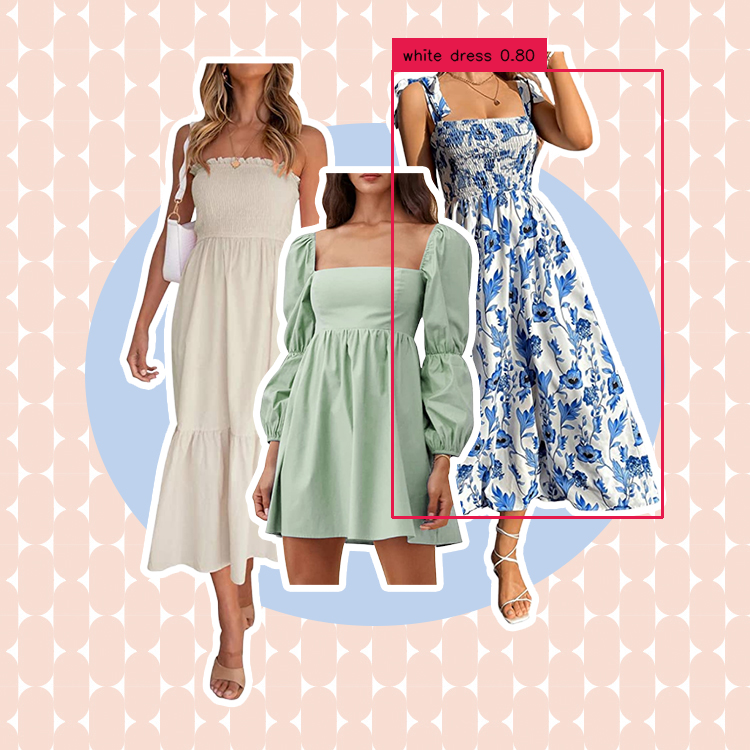

In [7]:
## Show detections
Image.fromarray(annotated_frame)

# Step2: Generate Segmentation with Detection Boxes as Prompts

In [8]:
%cd ../segment_anything/
%pip install -e .
## download the segment model
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


/home/ec2-user/SageMaker/miaobishenghua2/Grounded-Segment-Anything/segment_anything
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Obtaining file:///home/ec2-user/SageMaker/miaobishenghua2/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explic

#### Load libraries

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image

#### Helper functions

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

#### Generate segmentation masks

In [11]:
test_image_path = '../dino_input_single/test.jpg'
test_mask_path = '../dino_output_single/test_mask.png'

## Loading model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
## Inference
predictor = SamPredictor(sam)
image_pil_arry = np.array(Image.open(test_image_path).convert('RGB'))
predictor.set_image(image_pil_arry)
masks, _, _ = predictor.predict(
    box=dino_box[None, :],
    multimask_output=False,
)
## save the mask
Image.fromarray(masks[0]).save(test_mask_path)

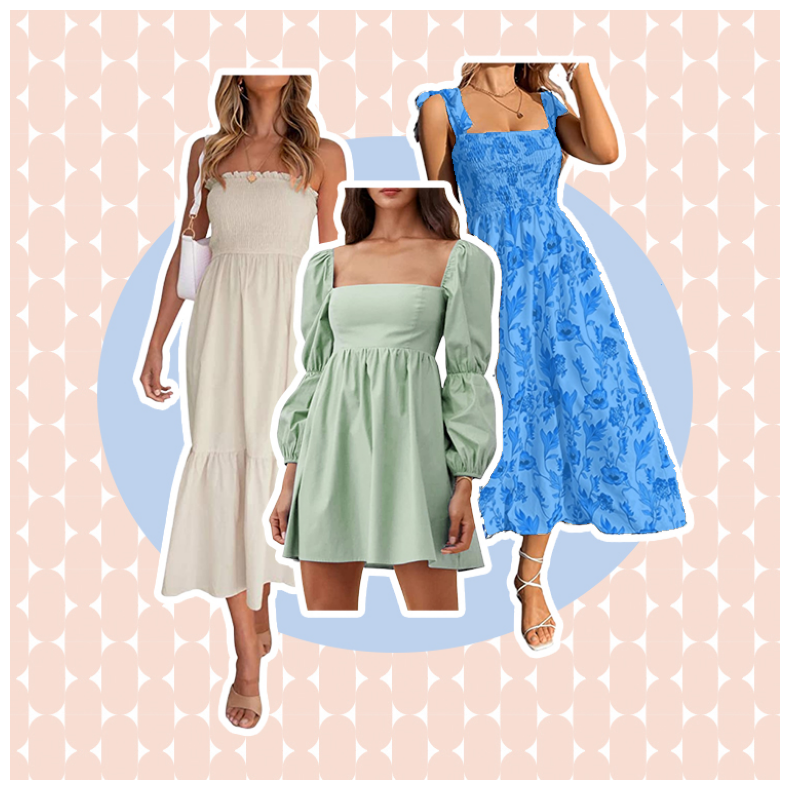

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(image_pil_arry )
show_mask(masks[0], plt.gca())
#show_box(dino_box, plt.gca())
plt.axis('off')
plt.show()

# Step3: Bonus Inpainting

#### Loading libraries

In [13]:
# diffusers
import torch
from diffusers import StableDiffusionInpaintPipeline
from diffusers import DDIMScheduler

#### Helper functions

In [14]:
def image_read(image_file):
    return Image.open(image_file).convert("RGB")

def mask_read(mask_file):
    return Image.open(mask_file).convert('1') 
    
def image_fuser(new_image, org_image, mask):
    new_image = np.array(new_image)
    org_image = np.array(org_image)
    mask = np.array(mask)
    org_image[mask] = new_image[mask]
    result = Image.fromarray(org_image)
    return result

def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
    # resize for inpainting 
    w, h = image.size
    in_image = image.resize((512, 512))
    in_mask = mask.resize((512, 512))
    generator = torch.Generator(device).manual_seed(seed) 
    image_gen = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
    image_gen = image_gen.images[0]
    result = image_fuser(image_gen, in_image, in_mask)
    result = result.resize((w, h))
    return result

#### Generating images

In [15]:
## Loading and config model
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16)
pipe = pipe.to('cuda')
# pipe.safety_checker = lambda images, clip_input: (images, False) # disable safety checker(not recommended)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
## Inference
inpaint_prompt = 'an extremely beautiful dreamy white lace cotton dress with delicate see-through sleeves, extra detailes, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3, photorealistic'
inpaint_negative_prompt="(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
seed = 512 # for reproducibility 
guidance_scale = 7.5
num_inference_steps = 50
org_image = image_read(test_image_path)
seg_mask = mask_read(test_mask_path)
inpainted_image = generate_image(org_image, seg_mask, inpaint_prompt, inpaint_negative_prompt, pipe, seed)

  0%|          | 0/50 [00:00<?, ?it/s]

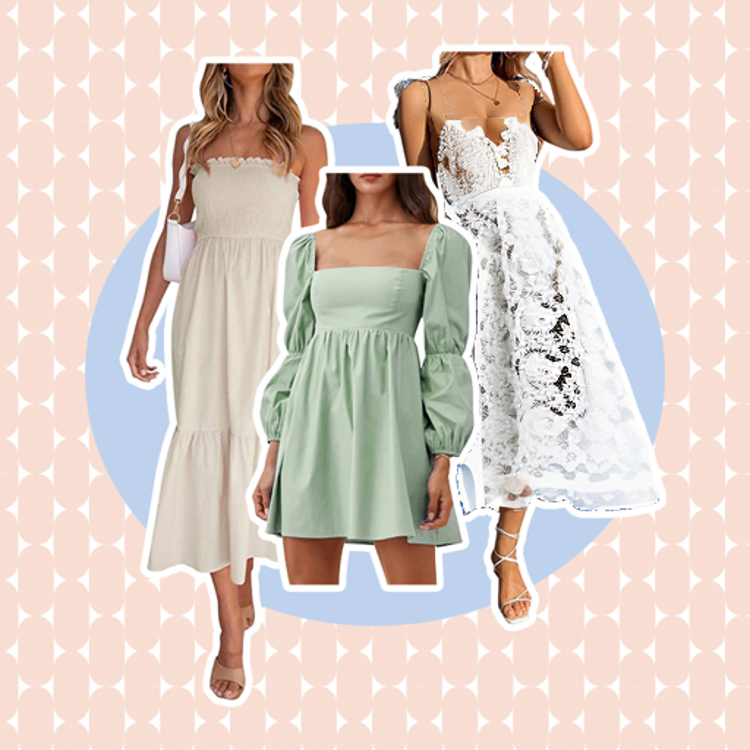

In [16]:
inpainted_image 